In [2]:
! pip install kagglehub


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sahilwagh_gold_stock_prices_path = kagglehub.dataset_download('sahilwagh/gold-stock-prices')

print('Data source import complete.')


c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


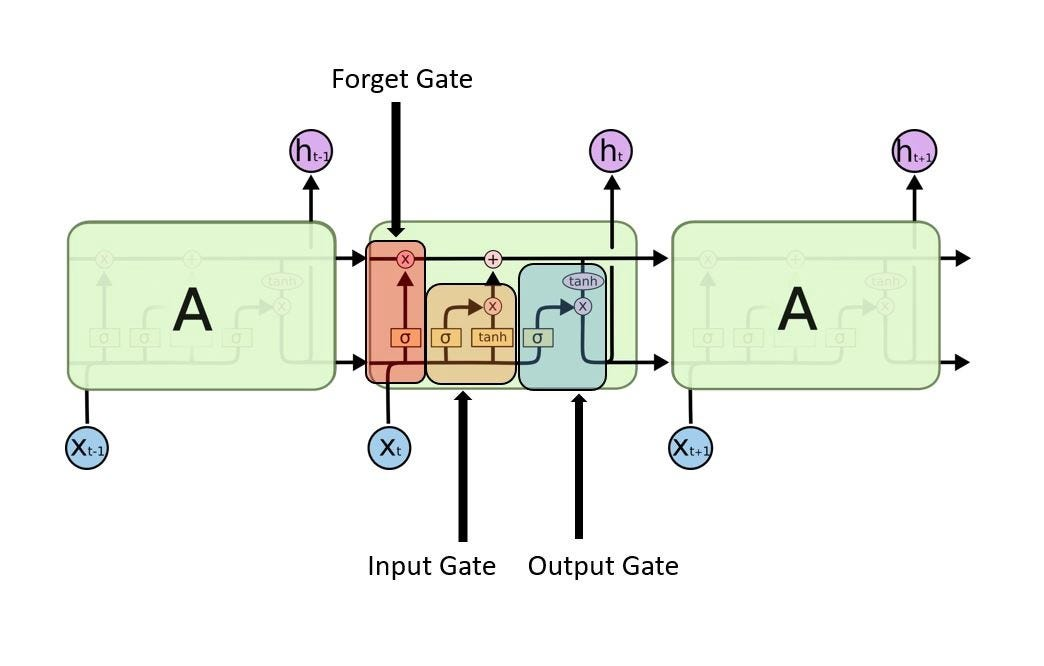


# Predicting the Price of Gold with an LSTM RNN
In this notebook I am using my new knowledge in LSTM RNNs to creat a model able to predict the price of gold. (This notebook is only for educational purposes)

In [2]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [3]:
EPOCHS = 50
BATCH_SIZE = 32
TIMESTEP = 60

DATA_PATH = "/kaggle/input/gold-stock-prices/goldstock.csv"

In [4]:
import kagglehub
import pandas as pd
import os

# Descargar la versión específica del dataset
path = kagglehub.dataset_download("sahilwagh/gold-stock-prices/versions/1")

# Mostrar el path completo
print("📁 Ruta del dataset descargado:", path)

# Verifica qué archivos contiene la carpeta
print("📄 Archivos disponibles:", os.listdir(path))

# Leer el CSV correcto (ajusta el nombre si es distinto)
csv_path = os.path.join(path, "goldstock.csv")  # o el nombre exacto del archivo que imprima os.listdir

df = pd.read_csv(csv_path)
print(df.head())


📁 Ruta del dataset descargado: C:\Users\Alumno_AI\.cache\kagglehub\datasets\sahilwagh\gold-stock-prices\versions\1
📄 Archivos disponibles: ['goldstock.csv']
   Unnamed: 0        Date   Close    Volume    Open    High     Low
0           0  2024-01-19  2029.3  166078.0  2027.4  2041.9  2022.2
1           1  2024-01-18  2021.6  167013.0  2009.1  2025.6  2007.7
2           2  2024-01-17  2006.5  245194.0  2031.7  2036.1  2004.6
3           3  2024-01-16  2030.2  277995.0  2053.4  2062.8  2027.6
4           4  2024-01-12  2051.6  250946.0  2033.2  2067.3  2033.1


### Helper Methods
Below I created a method that will fill in missing Dates with Open prices using the Close price from the previous active business day. These rows could be missing because the market is not open on holidays or weekends. By filling in these missing values we give ourselves more data for our model to train on

In [5]:
"""
  This function takes a dataframe and populates the missing dates in the
  dataframe with the open price set to the close price of the previous day.

  @param df: dataframe
  @return: fully populated dataframe
"""
def populate_missing_date_values(df):
  start_date = df['Date'][0].date()

  # store the dates as a Series
  dates = df['Date']

  dataset = []
  num_days_in_future = 1

  for index, day in enumerate(dates):
    # extract the date from the current row in the dataframe
    current_df_date = str(day.date())

    # skip the first date
    if (index == 0):
      # add the first date to the dataset
      open_price = df['Open'][index]
      day_step = [current_df_date, open_price]
      dataset.append(day_step)
      continue

    # get the open and close prices
    open_price = df['Open'][index]
    close_price = df['Close'][index - 1]

    # get the date of the next day
    current_date = str(start_date + datetime.timedelta(days = num_days_in_future))

    # check if the current date is the same as the current date in the dataframe
    if (current_date != current_df_date):
      found_next_date = False

      # loop until the next date is found
      while not found_next_date:
        if (current_date == current_df_date):
          found_next_date = True

          # add the open price to the dataset
          day_step = [current_date, open_price]
          dataset.append(day_step)
        else:
          # add the close price to the dataset
          day_step = [current_date, close_price]
          dataset.append(day_step)

          # increment the date
          num_days_in_future += 1
          current_date = str(start_date + datetime.timedelta(days=num_days_in_future))
    else:
      # add the open price to the dataset
      day_step = [current_date, open_price]
      dataset.append(day_step)

    num_days_in_future += 1

  return dataset

### Data Loading and Preprocessing
Here we are loading the data from the goldstock.csv into a Pandas dataframe. From there we will sort the dates in ascending order by date (earliest to latest).


Remove any duplicate rows in the dataframe. There are some here. Populte the missing dates/open prices using our helper function. Finally, store only the Date and Open columns in a dataframe

In [6]:
# load the gold stock csv into a dataframe

df['Date'] = pd.to_datetime(df['Date'])

# sort by Date - Earliest to latest
df = df.sort_values(by='Date', ascending=True)

# remove duplicate observations
df.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

# populate missing dates and open price values
df = populate_missing_date_values(df)

# create a dataframe with only Date and Open columns
df = pd.DataFrame(df, columns=['Date', 'Open'])
df.head(10)

,Date,Open
0,2014-01-22,1240.5
1,2014-01-23,1235.1
2,2014-01-24,1264.3
3,2014-01-25,1264.5
4,2014-01-26,1264.5
5,2014-01-27,1269.9
6,2014-01-28,1254.9
7,2014-01-29,1255.8
8,2014-01-30,1267.2
9,2014-01-31,1244.0


### Visualize the Gold Price Over the Past 10 Years

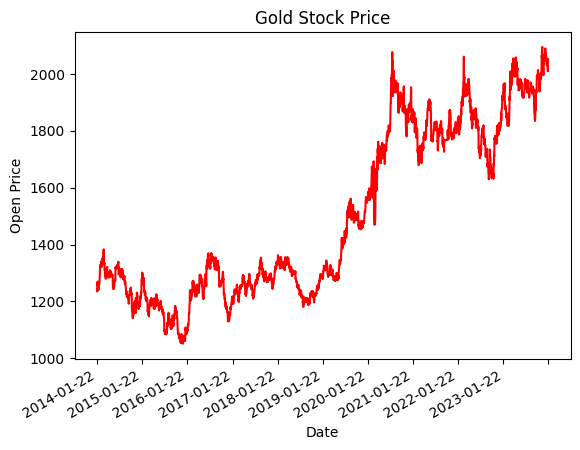

In [7]:
plt.plot(df['Date'], df['Open'], color='red')

locator = mdate.YearLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Gold Stock Price')
plt.show()

We will use all of the data up until the end of 2023 for our training set. Then we'll use the data for 2024 as the test set.

In [8]:
# extract the training data and verify it ends at the end of 2023
train_df = df.head(len(df) - 19)
train_df.tail()

,Date,Open
3626,2023-12-27,2079.3
3627,2023-12-28,2089.5
3628,2023-12-29,2076.1
3629,2023-12-30,2071.8
3630,2023-12-31,2071.8


In [9]:
# extact the test data and verify it starts at January 1st 2024
test_df = df.tail(19)
test_df.reset_index(drop=True, inplace=True)
test_df.head(19)

,Date,Open
0,2024-01-01,2071.8
1,2024-01-02,2072.7
2,2024-01-03,2067.9
3,2024-01-04,2049.3
4,2024-01-05,2051.4
5,2024-01-06,2049.8
6,2024-01-07,2049.8
7,2024-01-08,2052.6
8,2024-01-09,2034.5
9,2024-01-10,2036.0


### Process the Training Data
Extract the Open values into a NumPy array and then scale those values to between 0 and 1. Then create time step batches of the training dataset and training label set.  

In [10]:
# extract the Open values into a numpy array
X_train = train_df.iloc[:, 1:2].values

In [11]:
sc = MinMaxScaler(feature_range=(0, 1))

# fit the scaler only on X_train
sc.fit(X_train)

# scale X_train values to between 0 and 1
X_train_scaled = sc.transform(X_train)

In [12]:
train_data = []
train_labels = []

# create the training data using 60 timesteps
for i in range(TIMESTEP, len(X_train_scaled)):
  train_data.append(X_train_scaled[i-TIMESTEP:i, 0])
  train_labels.append(X_train_scaled[i, 0])

# convert train_data and train_labels back into numpy arrays
train_data, train_labels = np.array(train_data), np.array(train_labels)

# reshape train_data to be 3D so its compatible with the RNNs input requirements
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))

Validating that our training data is in the correct shape we see that we have 3571 observations in our training data, 60 timesteps and 1 vector input '**Open**'

In [13]:
print(f"Training Data Shape: {train_data.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Data Shape: (3571, 60, 1)
Training Labels Shape: (3571,)


In [14]:
print("NaN en train_data:", np.isnan(train_data).sum())
print("NaN en train_labels:", np.isnan(train_labels).sum())


NaN en train_data: 0
NaN en train_labels: 0


### Create, Compile and Fit the LSTM RNN Model

In [15]:
regressor = Sequential()

# ✅ Primera capa LSTM debe devolver secuencias si hay otra LSTM después
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1))))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=60, return_sequences=True)))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=80, return_sequences=True)))
regressor.add(Dropout(0.2))

# ✅ Última LSTM no devuelve secuencias
regressor.add(Bidirectional(LSTM(units=120)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))  # salida escalar



c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:

# ⚠️ Corrección aquí también: la función de pérdida debe ser 'mean_squared_error', no 'adam'
regressor.compile(optimizer='adam', loss='mean_squared_error')


In [17]:

# Entrenamiento
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)
history = regressor.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0260
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0023
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0016
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0014
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0013
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0018
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0012
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0015
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0012
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0011
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 9.3423e-04
Epoch 12/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0011
Epoch 13/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 9.6748e-04
Epoch 14/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 8.8358e-04
Epoch 15/50
112/112 ━━━━━━━━━━

### Evaluate Model Predictions on Test Data

In [18]:
last_60_days_2023 = train_df.iloc[:, 1:2].tail(TIMESTEP)
last_60_days_2023 = pd.concat([last_60_days_2023, test_df.iloc[:, 1:2]])
last_60_days_2023 = sc.transform(last_60_days_2023)

X_test = []
for i in range(TIMESTEP, 79):
  X_test.append(last_60_days_2023[i-TIMESTEP:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [19]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)
predicted_value

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


array([[2052.028 ],
       [2051.2913],
       [2052.3523],
       [2051.982 ],
       [2044.3793],
       [2039.1815],
       [2035.9412],
       [2034.5646],
       [2035.1741],
       [2028.434 ],
       [2023.3533],
       [2017.8988],
       [2016.4834],
       [2024.3138],
       [2031.294 ],
       [2035.6112],
       [2038.2374],
       [2030.9264],
       [2015.7743]], dtype=float32)

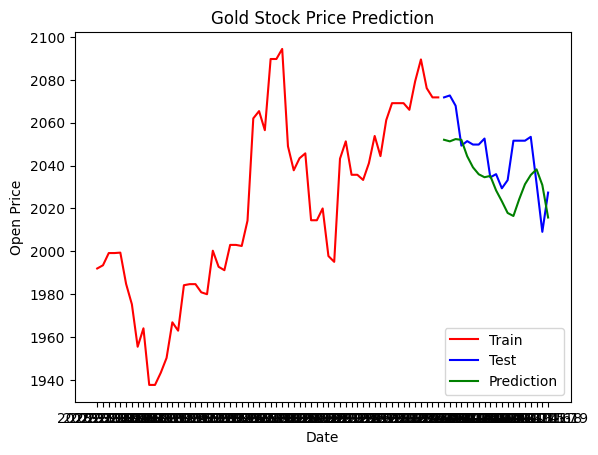

In [20]:
plt.plot(train_df.tail(TIMESTEP)['Date'], train_df.tail(TIMESTEP)['Open'], color='red')
plt.plot(test_df['Date'], test_df['Open'], color='blue')
plt.plot(test_df['Date'], predicted_value, color='green')
plt.title('Gold Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(['Train', 'Test', 'Prediction'], loc='lower right')

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Asegúrate de que ambas series tengan igual longitud
real = test_df['Open'].values[:len(predicted_value)]
pred = predicted_value[:len(real)].flatten()  # Asegura que esté en 1D

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(real, pred))
mae = mean_absolute_error(real, pred)
mape = np.mean(np.abs((real - pred) / real)) * 100
r2 = r2_score(real, pred)

# Precisión direccional
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
direccion_acertada = (real_diff == pred_diff)
precision_direccional = direccion_acertada.sum() / len(direccion_acertada) * 100

# Mostrar
print("📊 Métricas de rendimiento sobre los datos de test:")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE: {mae:.2f}")
print(f"🔹 MAPE: {mape:.2f}%")
print(f"🔹 R² Score: {r2:.4f}")
print(f"🔹 Precisión Direccional: {precision_direccional:.2f}%")


📊 Métricas de rendimiento sobre los datos de test:
🔹 RMSE: 16.96
🔹 MAE: 14.69
🔹 MAPE: 0.72%
🔹 R² Score: -0.1624
🔹 Precisión Direccional: 27.78%


In [25]:
last_60_days_2023 = train_df.iloc[:, 1:2].tail(TIMESTEP)
last_60_days_2023 = pd.concat([last_60_days_2023, test_df.iloc[:, 1:2]])
last_60_days_2023 = sc.transform(last_60_days_2023)


c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
from datetime import timedelta

# ✅ Últimos 60 días conocidos para predecir el futuro
last_sequence = last_60_days_2023[-TIMESTEP:].reshape(1, TIMESTEP, 1)

future_predictions = []

# 🔮 Predecimos día a día
for _ in range(5):
    prediction = regressor.predict(last_sequence)[0][0]
    future_predictions.append(prediction)

    # Actualizamos la secuencia: quitamos el primero, añadimos el nuevo
    new_sequence = np.append(last_sequence[0, 1:], [[prediction]], axis=0)
    last_sequence = new_sequence.reshape(1, TIMESTEP, 1)

# 🎯 Reescalar a valores reales
future_predictions_rescaled = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 📅 Generamos fechas futuras a partir de la última fecha conocida
last_date = pd.to_datetime(test_df['Date'].iloc[-1])
future_dates = [last_date + timedelta(days=i+1) for i in range(60)]

# 📄 Creamos el DataFrame
forecast_df = pd.DataFrame({
    'Fecha': future_dates,
    'Predicted_Oro': future_predictions_rescaled.flatten()
})
forecast_df = forecast_df.set_index('Fecha')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\2406475704.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\2406475704.py:16: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\2406475704.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\2406475704.py:16: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-pack

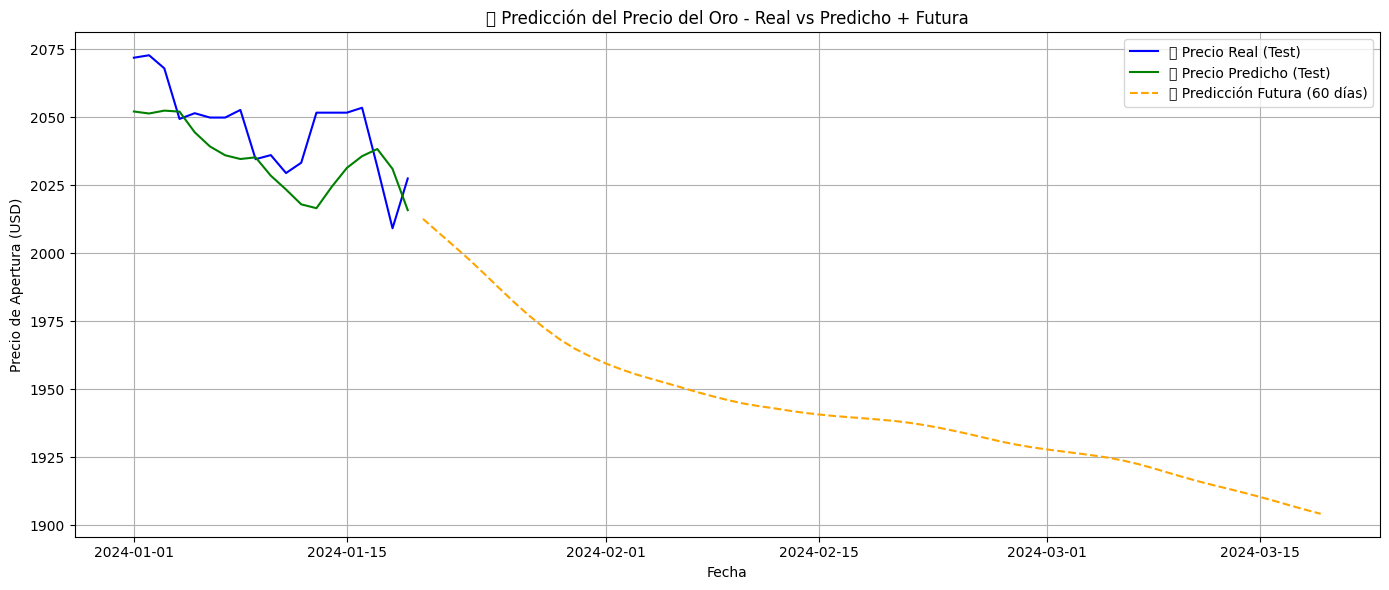

In [29]:
# 📌 Unimos predicciones futuras al dataframe
df_futuro = forecast_df.copy()  # forecast_df viene del bloque anterior
df_union = pd.concat([df_comparacion, df_futuro.rename(columns={'Predicted_Oro': 'Precio_Predicho'})])

# 📈 Graficar precios reales, predichos (test) y futuros
plt.figure(figsize=(14, 6))
plt.plot(df_comparacion['Precio_Real'], label='📉 Precio Real (Test)', color='blue')
plt.plot(df_comparacion['Precio_Predicho'], label='📈 Precio Predicho (Test)', color='green')
plt.plot(df_futuro['Predicted_Oro'], label='🔮 Predicción Futura (60 días)', linestyle='--', color='orange')

plt.title('📊 Predicción del Precio del Oro - Real vs Predicho + Futura')
plt.xlabel('Fecha')
plt.ylabel('Precio de Apertura (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\388294783.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\388294783.py:29: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_18256\388294783.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\

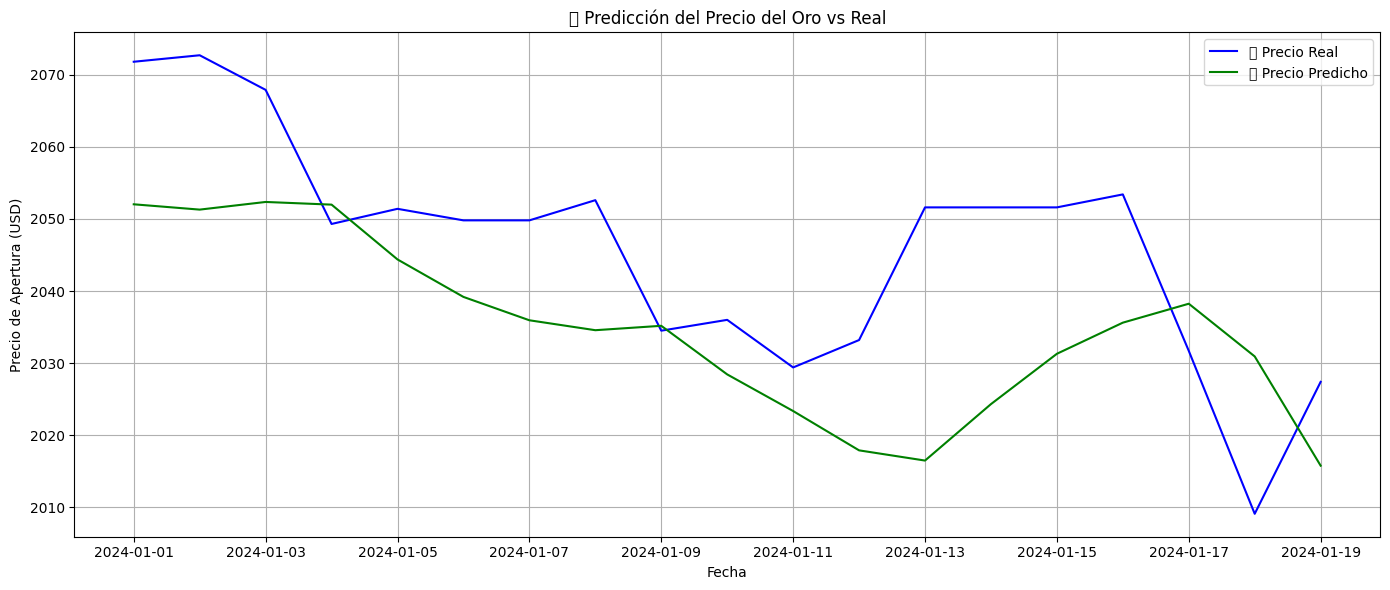

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarse de que las longitudes coincidan
real = test_df['Open'].values[:len(predicted_value)]
fechas = test_df['Date'].values[:len(predicted_value)]
pred = predicted_value.flatten()

# Crear el DataFrame de comparación
df_comparacion = pd.DataFrame({
    'Fecha': fechas,
    'Precio_Real': real,
    'Precio_Predicho': pred
})

# Establecer la fecha como índice
df_comparacion['Fecha'] = pd.to_datetime(df_comparacion['Fecha'])
df_comparacion = df_comparacion.set_index('Fecha')

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(df_comparacion['Precio_Real'], label='📉 Precio Real', color='blue')
plt.plot(df_comparacion['Precio_Predicho'], label='📈 Precio Predicho', color='green')
plt.title('📊 Predicción del Precio del Oro vs Real')
plt.xlabel('Fecha')
plt.ylabel('Precio de Apertura (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_9232\3567906953.py:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_9232\3567906953.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


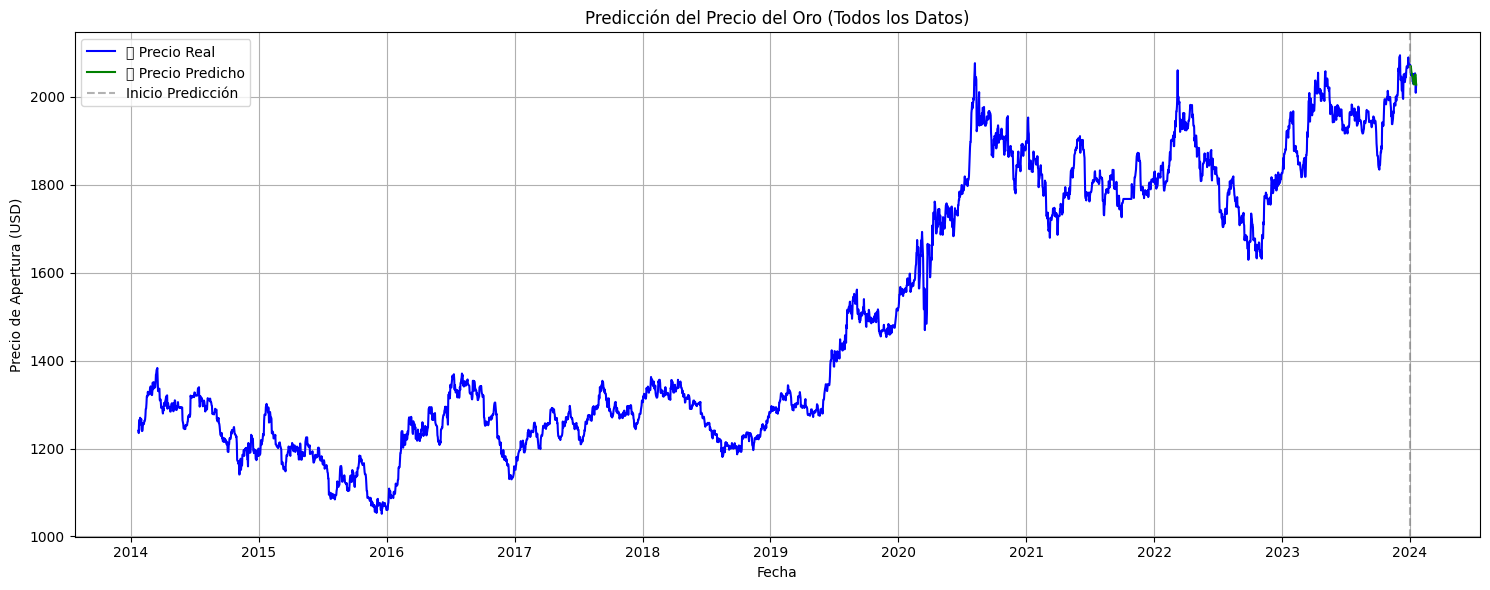

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Concatenar entrenamiento y test en un solo DataFrame real
df_real = pd.concat([train_df[['Date', 'Open']], test_df[['Date', 'Open']]], axis=0)
df_real['Date'] = pd.to_datetime(df_real['Date'])

# Predicciones solo para test: aseguramos que las fechas coincidan
df_pred = test_df[['Date']].copy()
df_pred['Date'] = pd.to_datetime(df_pred['Date'])
df_pred = df_pred.iloc[:len(predicted_value)].copy()
df_pred['Open'] = predicted_value.flatten()

# Gráfica
plt.figure(figsize=(15, 6))
plt.plot(df_real['Date'], df_real['Open'], label='📉 Precio Real', color='blue')
plt.plot(df_pred['Date'], df_pred['Open'], label='📈 Precio Predicho', color='green')
plt.axvline(df_pred['Date'].iloc[0], color='gray', linestyle='--', alpha=0.6, label='Inicio Predicción')
plt.title('Predicción del Precio del Oro (Todos los Datos)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Apertura (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluate the Model Loss

In [24]:
future_predictions = []
sequence = input_sequence.copy()

for _ in range(60):  # 60 días futuros
    x_input = sequence[-60:].reshape(1, 60, 1)
    y_pred = model.predict(x_input, verbose=0)
    
    future_predictions.append(y_pred[0, 0])
    sequence = np.vstack([sequence, [[y_pred[0, 0]]]])  # Añade el nuevo valor a la secuencia


NameError: name 'input_sequence' is not defined

Text(0.5, 0, 'Epoch')

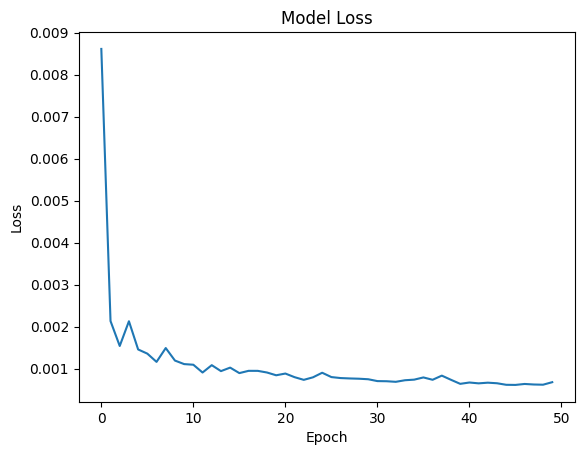

In [77]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')